In [142]:
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import remove_component, remove_holes
import numpy as np
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from scipy import signal
from skimage.morphology import skeletonize
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)
from scipy.interpolate import griddata
from PIL import Image
import pandas as pd
from scipy.optimize import curve_fit
plt.style.use('presentation.mplstyle')
from scipy.interpolate import interp1d
import scipy.optimize as opt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [389]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def Gaussian2d(x,y, sigma, x0,y0):    
    return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))
def twoD_Gaussian(xy, sigma,amp, x0, y0):
    x, y = xy
    g = amp*np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))
    return g.ravel()
def twoD_Gaussian_assym(xy, amplitude, xo, yo, sigma_x, sigma_y, offset):
    theta = 0
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = 1/sigma_x**2
    # b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    
    c = 1/sigma_y**2
    g = offset + amplitude*np.exp( -1/2*(a*((x-xo)**2)
                            + c*((y-yo)**2)))
    return g.ravel()

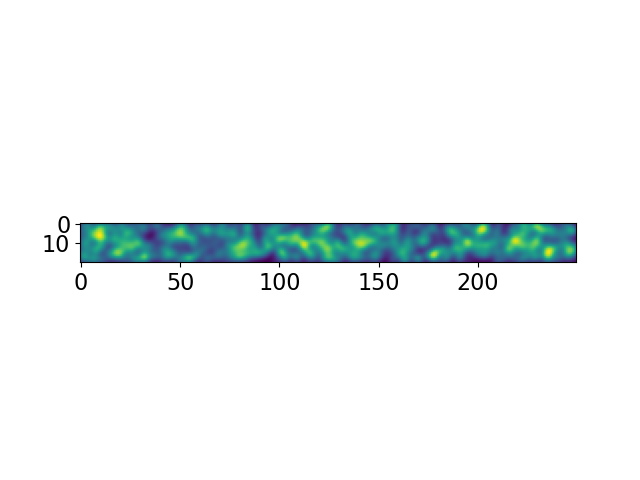

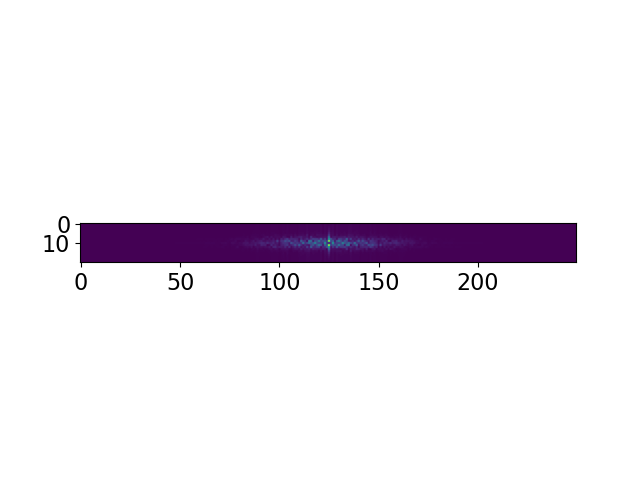

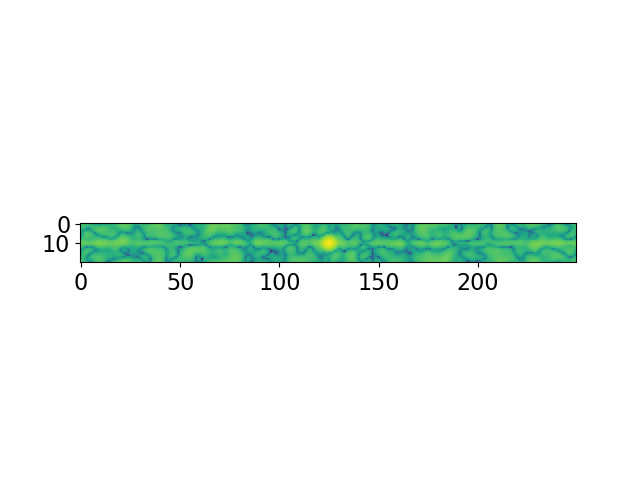

In [436]:
Nx= 250
Ny = 20

maxix = 250
maxiy= 20
x = np.linspace(0,maxix,Nx)
y = np.linspace(0,maxiy,Ny)
x,y = np.meshgrid(x,y)
x0 = maxix//2
y0 = maxiy//2
sigma =2
fig,ax = plt.subplots()
k = 1000
x0s = np.random.random(k)*maxix
y0s = np.random.random(k)*maxiy
image = np.sum([Gaussian2d(x,y,sigma,x0,y0) for (x0,y0) in zip(x0s,y0s)],axis=0)/k
ax.imshow(image)
ZMUV_image= (image-np.mean(image))/np.std(image)
# ZMUV_image=image
dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(ZMUV_image))
fig,ax = plt.subplots()
ax.imshow(abs(dark_image_grey_fourier))
autocorrelation = np.fft.ifftshift(np.fft.ifft2(abs(dark_image_grey_fourier)))
fig,ax = plt.subplots()
ax.imshow(np.log(abs(autocorrelation)))

In [437]:
amplitude = np.max(abs(dark_image_grey_fourier))
dark_image_grey_fourier[dark_image_grey_fourier.shape[0]//2,dark_image_grey_fourier.shape[1]//2]=amplitude
initial_guess = (1,amplitude,maxix/2,maxiy/2)
popt1, pcov = opt.curve_fit(twoD_Gaussian, (x, y), abs(dark_image_grey_fourier).ravel(), p0=initial_guess)

initial_guess = (amplitude,maxix/2,maxiy/2,1,1,10)
popt2, pcov = opt.curve_fit(twoD_Gaussian_assym, (x, y), abs(dark_image_grey_fourier).ravel(), p0=initial_guess)


In [438]:
1/(2*popt2[3]*np.pi)*maxix**2/Nx

2.3296533526387355

In [439]:
1/(2*popt2[4]*np.pi)*maxiy**2/Ny

1.6935862537895876

In [353]:
sigma_fourrier = np.sqrt(popt[4]*popt[3]*maxix/Nx*maxiy/Ny)

IndexError: index 4 is out of bounds for axis 0 with size 4

In [297]:
sigma_fourrier * sigma

0.29343726805239073

In [329]:
popt

array([4.51126624e+04, 1.50300601e+01, 1.50300601e+01, 3.64012592e-01,
       4.55429074e-01, 8.94581647e+00])

In [325]:
sigmax = popt[4]

In [328]:
1/(4*sigmax)*np.pi*maxix/Nx

0.10347141296133738

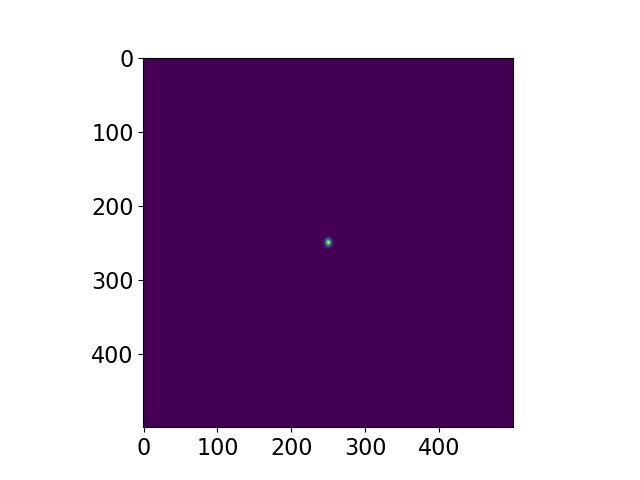

In [327]:
fig, ax = plt.subplots()
data_fitted = twoD_Gaussian_assym((x, y), *popt)
#ax.hold(True) For older versions. This has now been deprecated and later removed
# ax.imshow(abs(dark_image_grey_fourier), cmap=plt.cm.jet, origin='lower',
#     extent=(x.min(), x.max(), y.min(), y.max()))
# ax.contour(x, y, data_fitted.reshape(N, N), 8, colors='w')
ax.imshow(data_fitted.reshape(Ny, Nx))

plt.show()

C:\Users\coren\AppData\Local\Temp\ipykernel_2780\1534126682.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,images[100]))


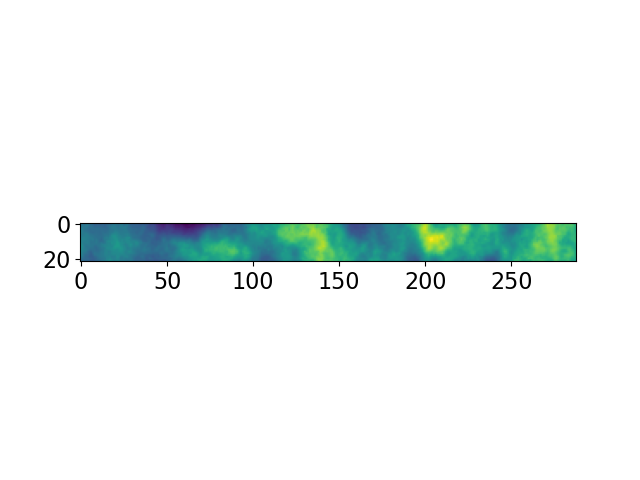

In [410]:
images_path = 'spatial_frequ'
images = os.listdir(images_path)
image = imageio.imread(os.path.join(images_path,images[100]))
binning = 2
magnification = 50
space_pixel_size = 2*1.725/(magnification)*binning #um.pixel
fig,ax =plt.subplots()
num = 10
squared = np.concatenate([np.flip(image[:,:num*image.shape[0]],axis=0) if i%2==0 else image[:,:num*image.shape[0]] for i in range(num)])
squared = image

ax.imshow(squared)

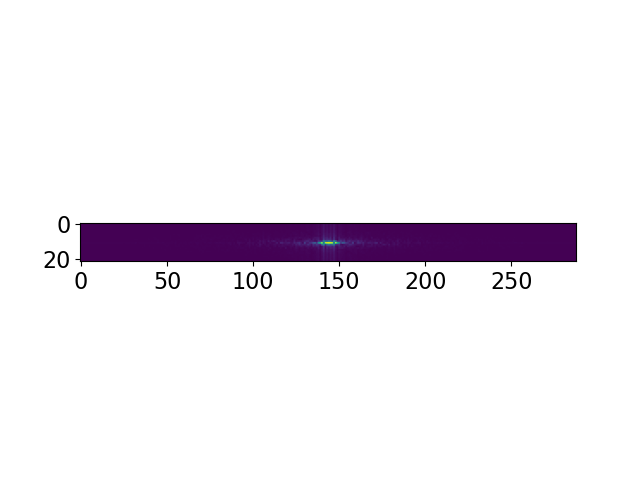

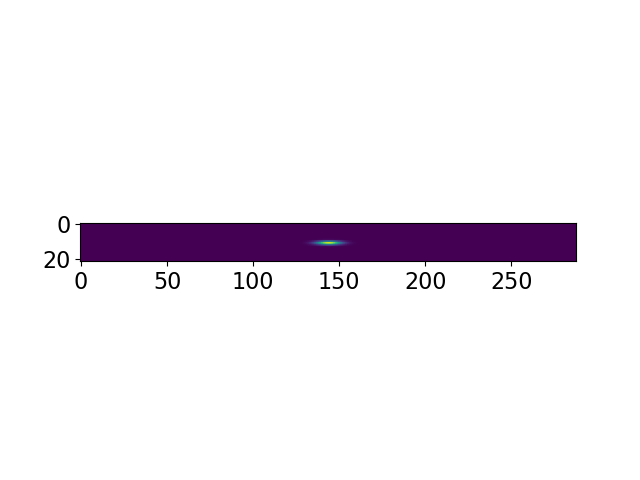

In [413]:
Nx = image.shape[1]
Ny = image.shape[0]
maxix = Nx*space_pixel_size
maxiy = Ny*space_pixel_size

x = np.linspace(0,maxix,Nx)
y = np.linspace(0,maxiy,Ny)
x,y = np.meshgrid(x,y)
ZMUV_image= (squared-np.mean(squared))/np.std(squared)
# ZMUV_image=image
dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(ZMUV_image))


autocorrelation = np.fft.ifftshift(np.fft.ifft2(abs(dark_image_grey_fourier)))
# fig,ax = plt.subplots()
# ax.imshow(np.log(abs(autocorrelation)))
amplitude = np.max(abs(dark_image_grey_fourier))
dark_image_grey_fourier[dark_image_grey_fourier.shape[0]//2,dark_image_grey_fourier.shape[1]//2]=amplitude
fig,ax = plt.subplots()
ax.imshow(abs(dark_image_grey_fourier))
initial_guess = (amplitude,space_pixel_size * Nx/2,space_pixel_size*Ny/2,1,1,10)
popt2, pcov = opt.curve_fit(twoD_Gaussian_assym, (x, y), abs(dark_image_grey_fourier).ravel(), p0=initial_guess)
fig, ax = plt.subplots()
data_fitted = twoD_Gaussian_assym((x, y), *popt2)
#ax.hold(True) For older versions. This has now been deprecated and later removed
# ax.imshow(abs(dark_image_grey_fourier), cmap=plt.cm.jet, origin='lower',
#     extent=(x.min(), x.max(), y.min(), y.max()))
# ax.contour(x, y, data_fitted.reshape(N, N), 8, colors='w')
ax.imshow(data_fitted.reshape(Ny, Nx))



In [414]:
1/(2*popt2[4]*np.pi)*maxiy**2/Ny


0.6419766618267899

In [416]:
1/(2*popt2[3]*np.pi)*maxix**2/Nx


1.2393651252658817

In [236]:
popt

array([1.72557078e+03, 1.99412489e+01, 1.59028640e+00, 7.07243193e-01,
       1.03223968e-01, 1.12403389e+07, 1.15601166e+01])

In [337]:
ydata = abs(dark_image_grey_fourier).ravel()
xdata = (x, y)
f = twoD_Gaussian_assym
residuals = ydata- f(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

TypeError: twoD_Gaussian_assym() missing 2 required positional arguments: 'sigma_y' and 'offset'

In [179]:
1/(4*popt[3])*np.pi*1/space_pixel_size,1/(4*popt[4])*np.pi*1/space_pixel_size,

(99.57089345042269, 6.894436133695877)

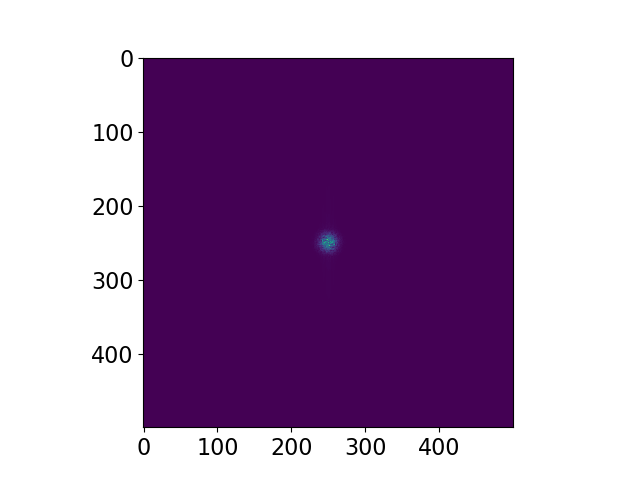

In [38]:
fig,ax = plt.subplots()

ax.imshow(abs(dark_image_grey_fourier))


In [ ]:
centerx  = image.shape[0]//2
centery  = image.shape[1]//2
coordinates1 = np.array([[np.sqrt((i)**2+(j)**2) for j in range(autocorrelation.shape[1])] for i in range(autocorrelation.shape[0])])
coordinates2 = np.array([[np.sqrt((i-image.shape[0]+1)**2+(j)**2) for j in range(autocorrelation.shape[1])] for i in range(autocorrelation.shape[0])])
distance = np.min((coordinates1,coordinates2),axis=0)
fig,ax = plt.subplots()
ax.imshow(distance)

In [ ]:
fig,ax = plt.subplots()
data = pd.DataFrame(np.array((distance.flatten(),abs(autocorrelation).flatten())).transpose())
data['distance']=data[0].astype(int)
autococ = data.groupby("distance")[1].mean()
ax.plot(autococ.index*space_pixel_size,autococ)

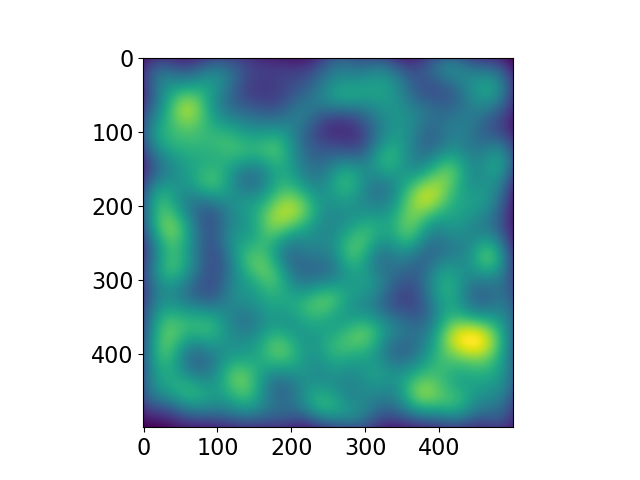

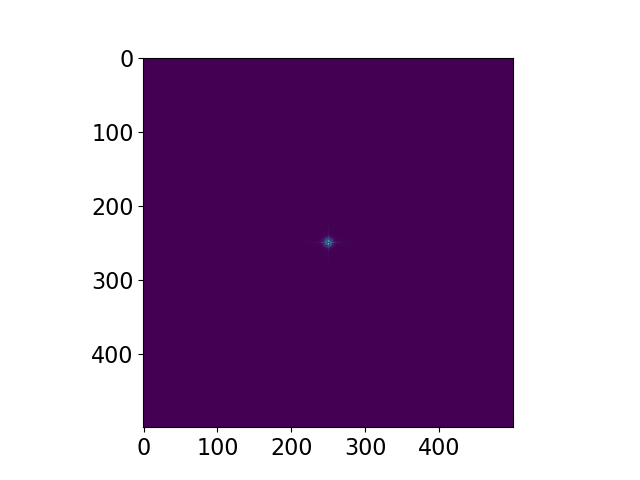

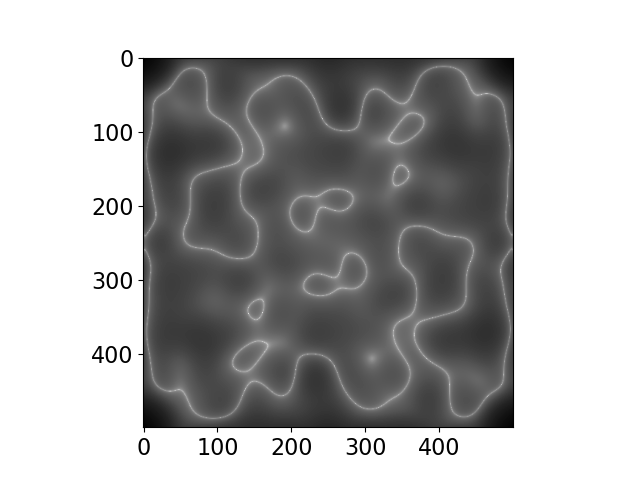

In [140]:
N = 500
maxi = 10
x = np.linspace(0,maxi,N)
y = np.linspace(0,maxi,N)
x,y = np.meshgrid(x,y)
x0 = maxi//2
y0 = maxi//2
sigma =1
fig,ax = plt.subplots()
k = 1000
x0s = np.random.random(k)*maxi
y0s = np.random.random(k)*maxi
signal = np.sum([Gaussian2d(x,y,sigma,x0,y0) for (x0,y0) in zip(x0s,y0s)],axis=0)
ax.imshow(signal)
ZMUV_image= (signal-np.mean(signal))/np.std(signal)
dark_image_grey_fourier = abs(np.fft.fftshift(np.fft.fft2(ZMUV_image)))
fig,ax = plt.subplots()
ax.imshow(dark_image_grey_fourier)
autocorrelation = np.fft.ifft2(dark_image_grey_fourier)
fig,ax = plt.subplots()
ax.imshow(np.log(abs(autocorrelation)),cmap="Greys")

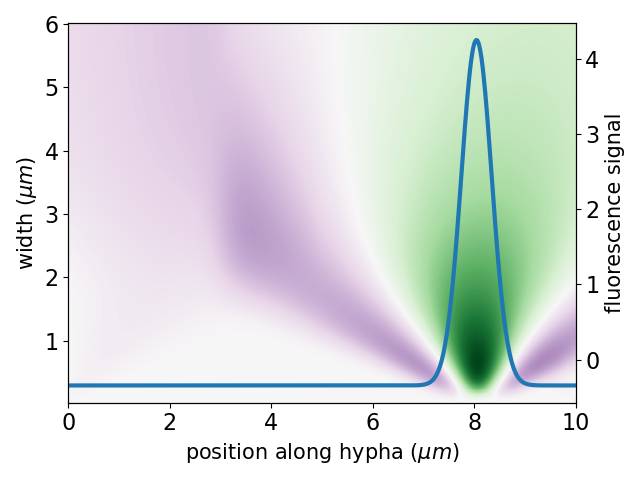

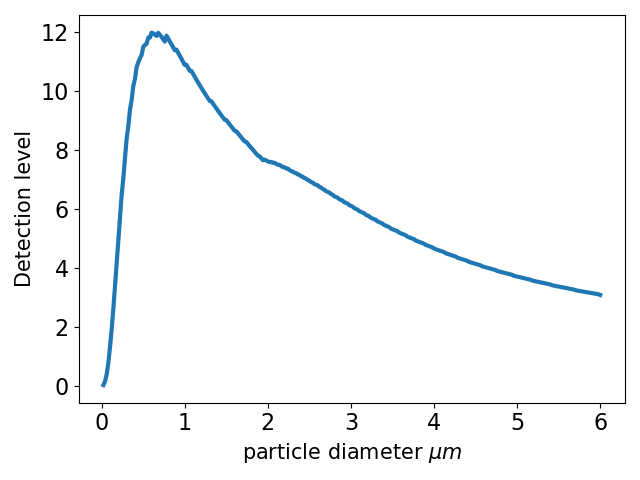

In [24]:
N = 500
maxi = 10
t = np.linspace(0,maxi,N)
H = 0
A=1
x0 = 0.5
sigma = 0.3
num = 1
x0s = np.random.random(num)*maxi
signal0= np.sum([gauss(t, H, A, x0, sigma) for x0 in x0s],axis=0)
width_max = 301
line = signal0
ZMUV_signal = (line-np.mean(line))/np.std(line)
sig  = ZMUV_signal
widths = np.arange(1, width_max)

cwtmatr = signal.cwt(sig, signal.ricker, widths)
cwtmatr_yflip = np.flipud(cwtmatr)
# fig,ax =plt.subplots()
fig,ax =plt.subplots()
# transform = cwtmatr_yflip/np.array([np.flip(widths) for i in range(cwtmatr_yflip.shape[1])]).transpose()**2
transform = cwtmatr_yflip

# ax.imshow(cwtmatr_yflip, extent=[0, len(sig), 1, 31], cmap='PRGn', aspect='auto',

#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
ax.imshow(transform, extent=[0, len(sig)*maxi/N, 1*maxi/N, width_max*maxi/N], cmap='PRGn', aspect='auto',

           vmax=abs(transform).max(), vmin=-abs(transform).max(),)
ax2 = ax.twinx()
ax2.plot(np.array(range(len(sig)))*maxi/N,sig)
ax.set_xlabel('position along hypha ($\mu m$)')
ax.set_ylabel('width ($\mu m$)')
ax2.set_ylabel('fluorescence signal')
plt.tight_layout()
fig,ax =plt.subplots()
frequency1 = np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(N)]).transpose(),axis=1)
ax.plot(np.flip(widths)*maxi/N,frequency1)


ax.set_xlabel('particle diameter $\mu m$')
ax.set_ylabel('Detection level')
plt.tight_layout()

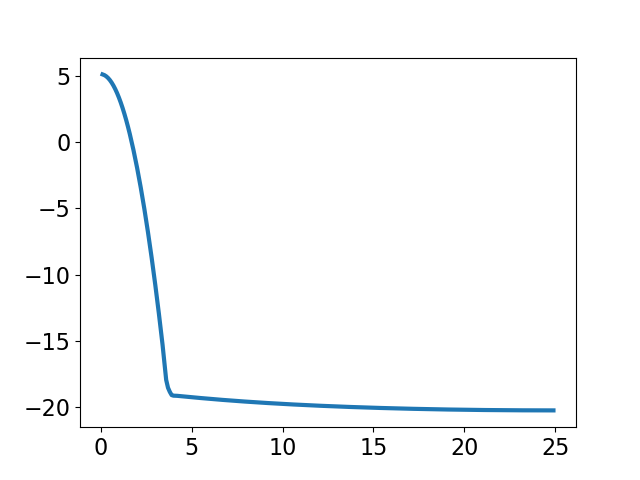

In [25]:
fourrier = np.fft.fft(ZMUV_signal)
freqs  = np.fft.fftfreq(len(ZMUV_signal),maxi/N)

fig,ax = plt.subplots()
ax.plot(freqs[1:len(fourrier)//2],np.log(abs(fourrier))[1:len(fourrier)//2])
# ax

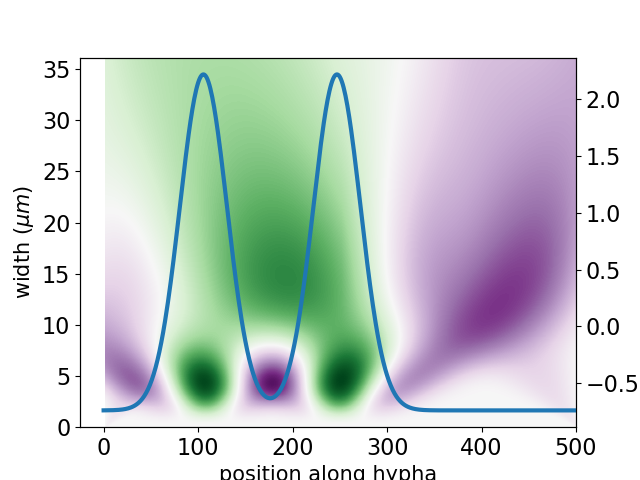

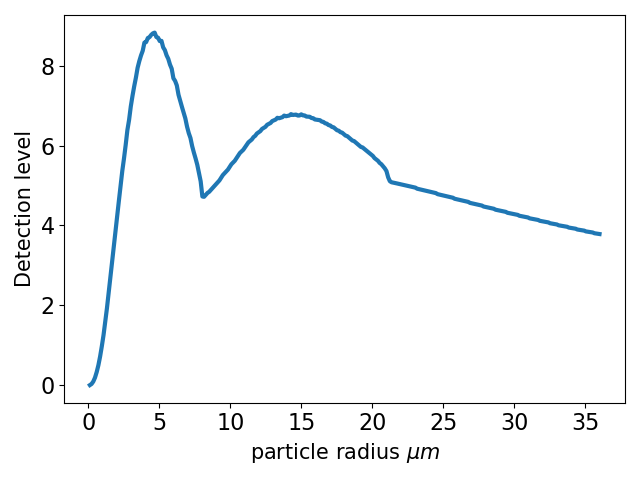

In [139]:
N = 500
maxi = 60
t = np.linspace(0,maxi,N)
H = 0
A=1
x0 = 0.5
sigma = 3
num = 2
x0s = np.random.random(num)*maxi
signal0= np.sum([gauss(t, H, A, x0, sigma) for x0 in x0s],axis=0)
width_max = 301
line = signal0
ZMUV_signal = (line-np.mean(line))/np.std(line)
sig  = ZMUV_signal
widths = np.arange(1, width_max)

cwtmatr = signal.cwt(sig, signal.ricker, widths)
cwtmatr_yflip = np.flipud(cwtmatr)
# fig,ax =plt.subplots()
fig,ax =plt.subplots()
# transform = cwtmatr_yflip/np.array([np.flip(widths) for i in range(cwtmatr_yflip.shape[1])]).transpose()**2
transform = cwtmatr_yflip

# ax.imshow(cwtmatr_yflip, extent=[0, len(sig), 1, 31], cmap='PRGn', aspect='auto',

#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
ax.imshow(transform, extent=[1, len(sig), 0, width_max*maxi/N], cmap='PRGn', aspect='auto',

           vmax=abs(transform).max(), vmin=-abs(transform).max(),)
ax2 = ax.twinx()
ax2.plot(sig)
ax.set_xlabel('position along hypha')
ax.set_ylabel('width ($\mu m$)')
ax2.set_ylabel('fluorescence signal')

fig,ax =plt.subplots()
frequency2 = np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(N)]).transpose(),axis=1)

ax.plot(np.flip(widths)*maxi/N,np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(N)]).transpose(),axis=1))
# ax.plot(np.flip(widths)*maxi/N,np.sum(cwtmatr_yflip,axis=1))

ax.set_xlabel('particle radius $\mu m$')
ax.set_ylabel('Detection level')
plt.tight_layout()

Text(0, 0.5, 'Detection level')

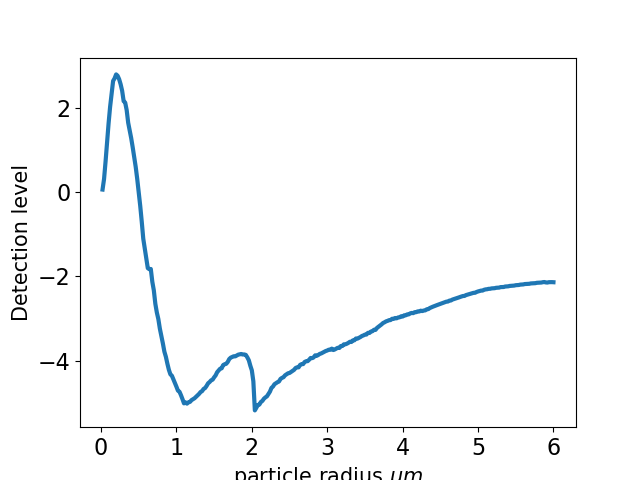

In [82]:
fig,ax =plt.subplots()
frequency2 = np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(N)]).transpose(),axis=1)

ax.plot(np.flip(widths)*maxi/N,frequency1-frequency2)
# ax.plot(np.flip(widths)*maxi/N,np.sum(cwtmatr_yflip,axis=1))

ax.set_xlabel('particle radius $\mu m$')
ax.set_ylabel('Detection level')

In [99]:
images_path = 'spatial_frequ'
images = os.listdir(images_path)
image = imageio.imread(os.path.join(images_path,images[100]))
binning = 2
magnification = 50
space_pixel_size = 2*1.725/(magnification)*binning #um.pixel

C:\Users\coren\AppData\Local\Temp\ipykernel_2780\3499247250.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,images[100]))


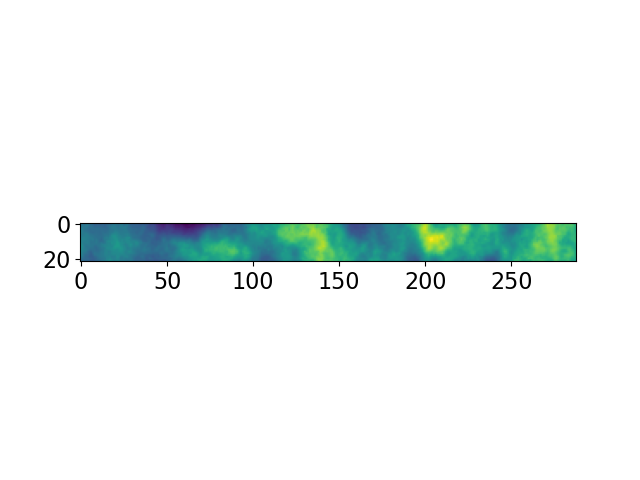

In [100]:
fig,ax =plt.subplots()
ax.imshow(image)

In [107]:
image[:,:num*image.shape[0]].shape

(22, 220)

In [23]:
i=10
line =image[i,:]
# ax.plot(line)
width_max = 51

ZMUV_signal = (line-np.mean(line))/np.std(line)
sig  = ZMUV_signal
widths = np.arange(1, width_max)

cwtmatr = signal.cwt(sig, signal.ricker, widths)
cwtmatr_yflip = np.flipud(cwtmatr)
# fig,ax =plt.subplots()
fig,ax =plt.subplots()
# transform = cwtmatr_yflip/np.array([np.flip(widths) for i in range(cwtmatr_yflip.shape[1])]).transpose()**2
transform = cwtmatr_yflip

# ax.imshow(cwtmatr_yflip, extent=[0, len(sig), 1, 31], cmap='PRGn', aspect='auto',

#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
ax.imshow(transform, extent=[0, len(sig)*space_pixel_size, 1, width_max*space_pixel_size], cmap='PRGn', aspect='auto',

           vmax=abs(transform).max(), vmin=-abs(transform).max(),)
ax2 = ax.twinx()
ax2.plot(np.array(range(len(sig)))*space_pixel_size,sig)
ax.set_xlabel('position along hypha')
ax.set_ylabel('width ($\mu m$)')
ax2.set_ylabel('fluorescence signal')
plt.tight_layout()
fig,ax =plt.subplots()
frequency_image = np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(image.shape[1])]).transpose(),axis=1)

# ax.plot(np.flip(widths)*space_pixel_size/2,np.mean(abs(cwtmatr_yflip),axis=1))
ax.plot(np.flip(widths)*space_pixel_size/2,frequency_image)

ax.set_xlabel('particle radius $\mu m$')
ax.set_ylabel('Detection level')
plt.tight_layout()

AttributeError: 'numpy.ndarray' object has no attribute 'cwt'

In [9]:
N = len(line)

def get_spectrum_random(sigma,num=30):
    maxi = N*space_pixel_size
    t = np.linspace(0,maxi,N)
    H = 0
    A=1
    x0 = 0.5
    x0s = np.random.random(num)*maxi
    signal0= np.sum([gauss(t, H, A, x0, sigma) for x0 in x0s],axis=0)
    width_max = 51
    line = signal0
    ZMUV_signal = (line-np.mean(line))/np.std(line)
    sig  = ZMUV_signal
    widths = np.arange(1, width_max)

    cwtmatr = signal.cwt(sig, signal.ricker, widths)
    cwtmatr_yflip = np.flipud(cwtmatr)
    frequency = np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(N)]).transpose(),axis=1)
    return(frequency)

def get_fourrier_spectrum_random(sigma,num=30):
    maxi = N*space_pixel_size
    t = np.linspace(0,maxi,N)
    H = 0
    A=1
    x0 = 0.5
    x0s = np.random.random(num)*maxi
    signal0= np.sum([gauss(t, H, A, x0, sigma) for x0 in x0s],axis=0)
    width_max = 51
    line = signal0
    ZMUV_signal = (line-np.mean(line))/np.std(line)
    fourrier = np.fft.fft(ZMUV_signal)
    return(abs(fourrier))

In [48]:
fourrier_specs = [get_fourrier_spectrum_random(1,30) for i in range(100)]
freq_fourrier_high =(np.mean(np.array(fourrier_specs),axis=0))
fourrier_specs = [get_fourrier_spectrum_random(5,10) for i in range(100)]
freq_fourrier_low =(np.mean(np.array(fourrier_specs),axis=0))

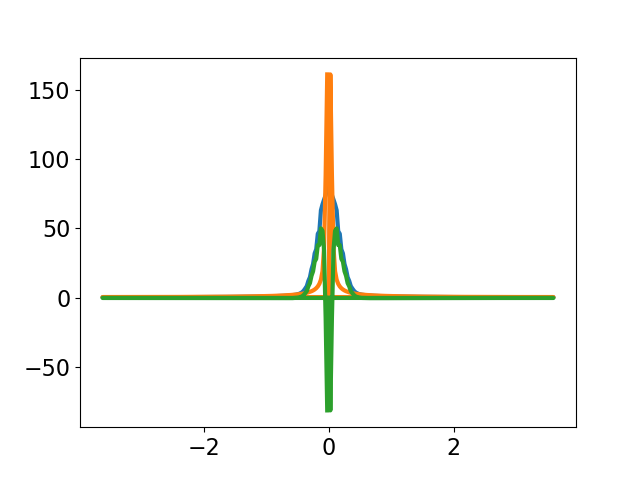

In [49]:
fig,ax =plt.subplots()
freqs  = np.fft.fftfreq(N,space_pixel_size)
ax.plot(freqs,freq_fourrier_high)
ax.plot(freqs,freq_fourrier_low)
ax.plot(freqs,freq_fourrier_high-freq_fourrier_low)


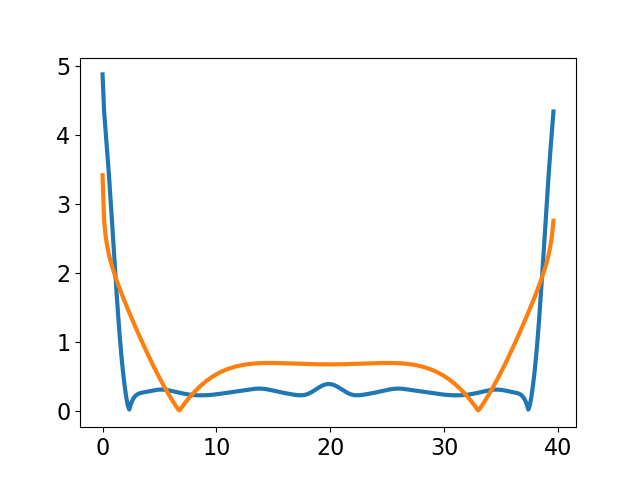

In [50]:
autocorrelation = np.fft.ifft(freq_fourrier_high)
autocorrelation2 = np.fft.ifft(freq_fourrier_low)

maxi = N*space_pixel_size

lag= np.linspace(0,maxi,N)
fig,ax = plt.subplots()
ax.plot(np.array(range(len(autocorrelation)))*space_pixel_size,abs(autocorrelation))
ax.plot(np.array(range(len(autocorrelation)))*space_pixel_size,abs(autocorrelation2))

In [ ]:
fig,ax =plt.subplots()
ax.plot(np.flip(widths)*space_pixel_size,freq_high,label='high frequency')
ax.plot(np.flip(widths)*space_pixel_size,freq_low,label='low frequency')
ax2 = ax.twinx()
ax2.plot(np.flip(widths)*space_pixel_size,freq_high-freq_low,label='difference',color='green',alpha = 0.5)

ax.set_xlabel('particle diameter $\mu m$')
ax.set_ylabel('Detection level')
ax.legend()
ax2.legend()
plt.tight_layout()

In [18]:
specs = [get_spectrum_random(6,10) for i in range(100)]
freq_low =(np.mean(np.array(specs),axis=0))
specs = [get_spectrum_random(0.5,30) for i in range(100)]
freq_high =(np.mean(np.array(specs),axis=0))

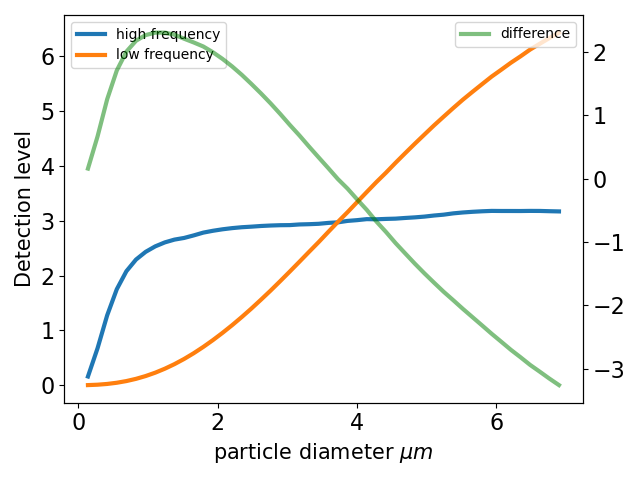

In [239]:
fig,ax =plt.subplots()
ax.plot(np.flip(widths)*space_pixel_size,freq_high,label='high frequency')
ax.plot(np.flip(widths)*space_pixel_size,freq_low,label='low frequency')
ax2 = ax.twinx()
ax2.plot(np.flip(widths)*space_pixel_size,freq_high-freq_low,label='difference',color='green',alpha = 0.5)

ax.set_xlabel('particle diameter $\mu m$')
ax.set_ylabel('Detection level')
ax.legend()
ax2.legend()
plt.tight_layout()

(-0.5, 3.0)

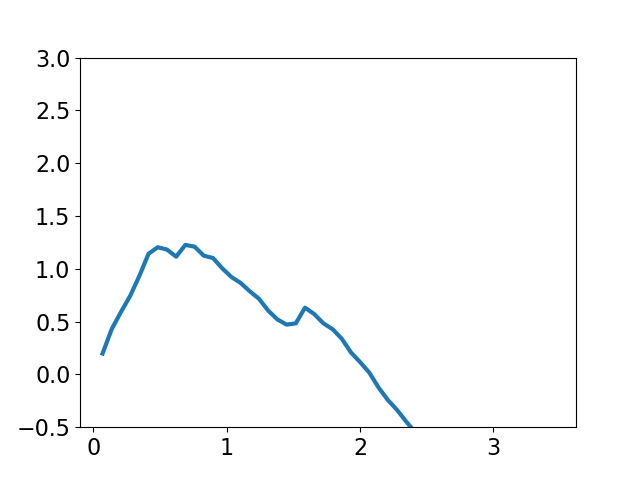

In [124]:
fig,ax =plt.subplots()
ax.plot(np.flip(widths)*maxi/N/2,frequency_image-freq_low)
ax.set_ylim(-0.5,3)

In [15]:
wavelets = []

for image_path in images[:-1:20]:
    image = imageio.imread(os.path.join(images_path,image_path))    
    for i in range(10,image.shape[0]-10):
        # fig,ax =plt.subplots()
        line =image[i,:]
        # ax.plot(line)
        ZMUV_signal = (line-np.mean(line))/np.std(line)
        sig  = ZMUV_signal
        cwtmatr = signal.cwt(sig, signal.ricker, widths)
        cwtmatr_yflip = np.flipud(cwtmatr)
        # transform = cwtmatr_yflip/np.array([np.flip(widths) for i in range(cwtmatr_yflip.shape[1])]).transpose()
        
        wavelet = np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(image.shape[1])]).transpose(),axis=1)
        wavelets.append(wavelet)

C:\Users\coren\AppData\Local\Temp\ipykernel_524\1685353466.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,image_path))


In [36]:
fourriers = []

for image_path in images[:-1:20]:
    image = imageio.imread(os.path.join(images_path,image_path))    
    for i in range(10,image.shape[0]-10):
        # fig,ax =plt.subplots()
        line =image[i,:]
        # ax.plot(line)
        ZMUV_signal = (line-np.mean(line))/np.std(line)
        fourrier = np.fft.fft(ZMUV_signal)

        fourriers.append(fourrier)
freq_fourrier_data =(np.mean(abs(np.array(fourriers)),axis=0))


C:\Users\coren\AppData\Local\Temp\ipykernel_524\4045572875.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,image_path))


In [ ]:
fig,ax = plt.subplots()


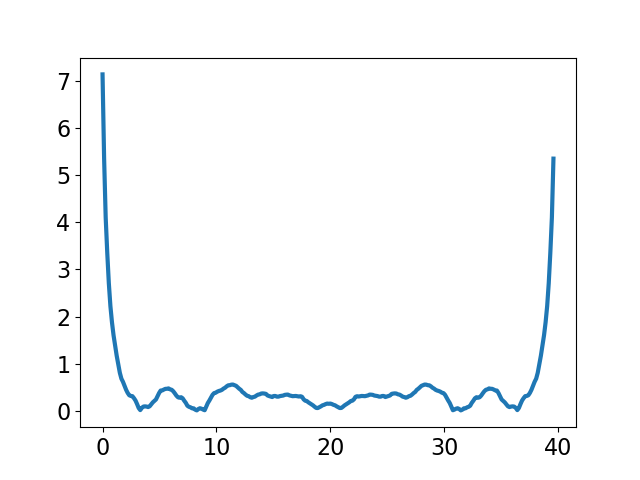

In [75]:
autocorrelation = np.fft.ifft(freq_fourrier_data)

fig,ax = plt.subplots()
ax.plot(np.array(range(len(autocorrelation)))*space_pixel_size,abs(autocorrelation))

In [24]:
fourrier2d = []

for image_path in images[::20]:
    image = imageio.imread(os.path.join(images_path,image_path))    
    ZMUV_image= (image-np.mean(image))/np.std(image)
    dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(ZMUV_image))
    fourrier2d.append(abs(dark_image_grey_fourier))

C:\Users\coren\AppData\Local\Temp\ipykernel_2780\1086598776.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,image_path))


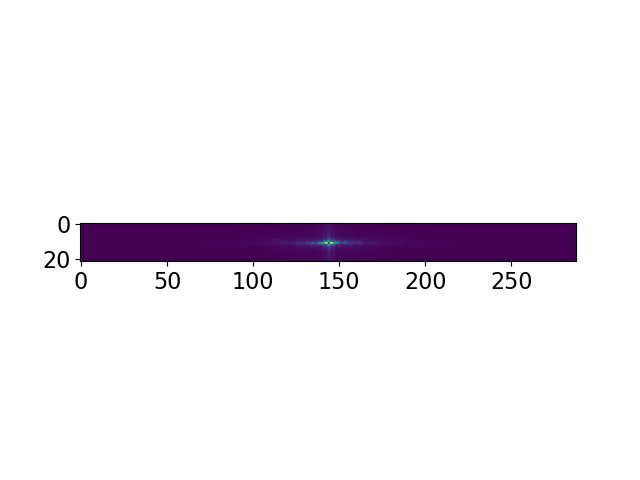

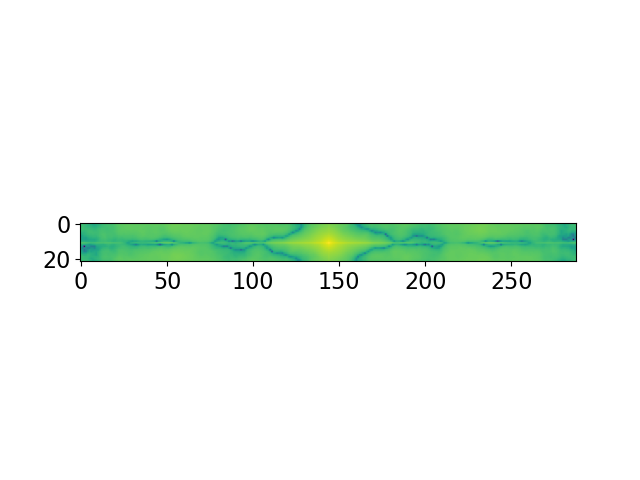

In [25]:
fourrier2d = np.array(fourrier2d)
average_fourrier_2d = np.mean(abs(fourrier2d),axis=0)
fig,ax = plt.subplots()
ax.imshow(average_fourrier_2d)
autocorrelation = np.fft.ifftshift(np.fft.ifft2(average_fourrier_2d))
fig,ax = plt.subplots()
ax.imshow(np.log(abs(autocorrelation)))


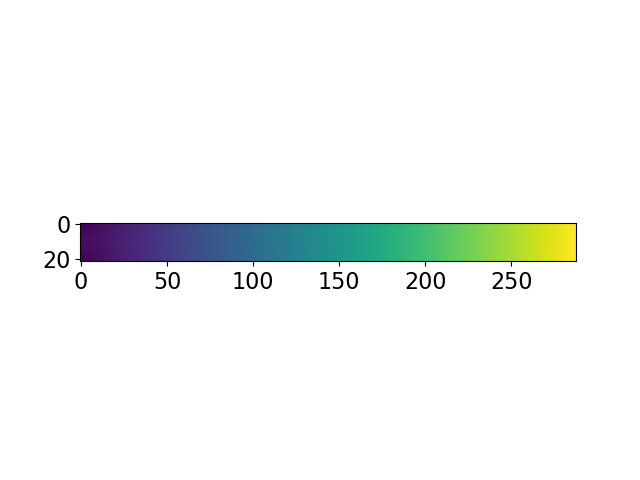

In [110]:
centerx  = image.shape[0]//2
centery  = image.shape[1]//2
coordinates1 = np.array([[np.sqrt((i)**2+(j)**2) for j in range(autocorrelation.shape[1])] for i in range(autocorrelation.shape[0])])
coordinates2 = np.array([[np.sqrt((i-image.shape[0]+1)**2+(j)**2) for j in range(autocorrelation.shape[1])] for i in range(autocorrelation.shape[0])])
distance = np.min((coordinates1,coordinates2),axis=0)
fig,ax = plt.subplots()
ax.imshow(distance)

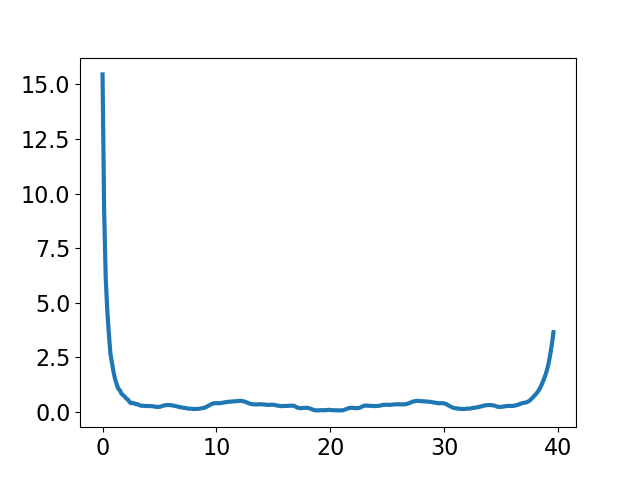

In [118]:
fig,ax = plt.subplots()
data = pd.DataFrame(np.array((distance.flatten(),abs(autocorrelation).flatten())).transpose())
data['distance']=data[0].astype(int)
autococ = data.groupby("distance")[1].mean()
ax.plot(autococ.index*space_pixel_size,autococ)

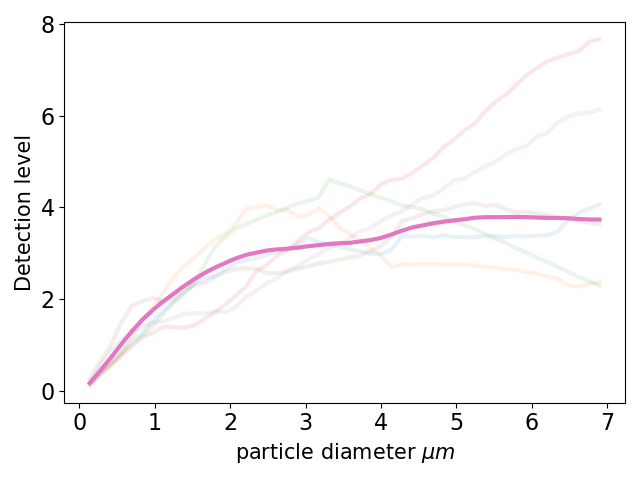

In [16]:
fig,ax =plt.subplots()
for wavelet in wavelets[::10]:
    ax.plot(np.flip(widths)*space_pixel_size,wavelet,alpha = 0.1)
ax.plot(np.flip(widths)*space_pixel_size,(np.mean(np.array(wavelets),axis=0)))
ax.set_xlabel('particle diameter $\mu m$')
ax.set_ylabel('Detection level')
plt.tight_layout()

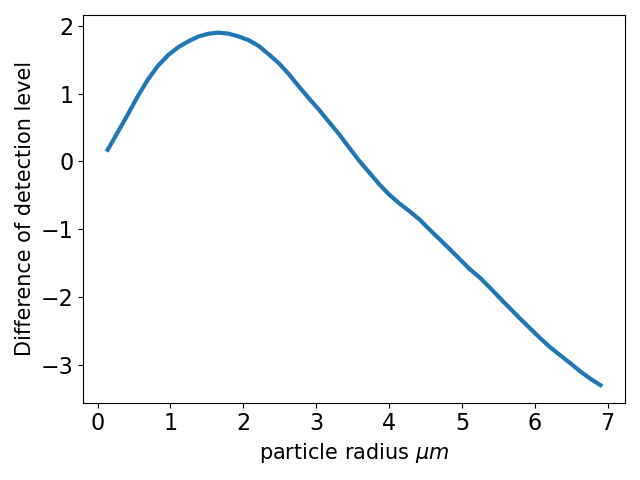

In [19]:
fig,ax =plt.subplots()
# for wavelet in wavelets[::200]:
#     ax.plot(widths*space_pixel_size,wavelet,alpha = 0.1)

ax.plot(np.flip(widths)*space_pixel_size,(np.mean(np.array(wavelets),axis=0)-freq_low))
ax.set_xlabel('particle radius $\mu m$')
ax.set_ylabel('Difference of detection level')
plt.tight_layout()

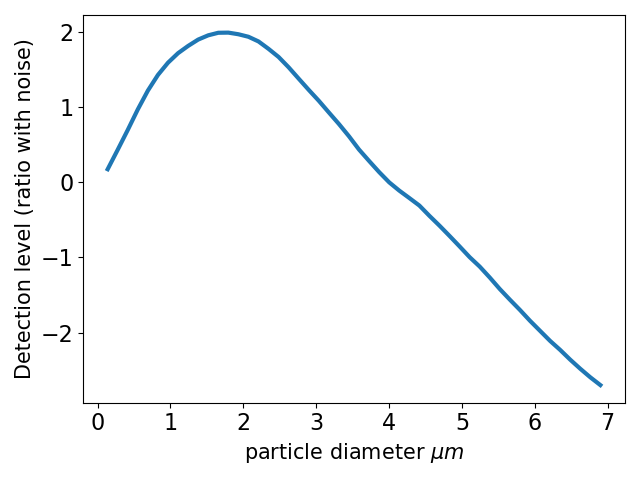

In [241]:
fig,ax =plt.subplots()
# for wavelet in wavelets[::200]:
#     ax.plot(widths*space_pixel_size,wavelet,alpha = 0.1)

ax.plot(np.flip(widths)*space_pixel_size,(np.mean(np.array(wavelets),axis=0)-freq_low))
ax.set_xlabel('particle diameter $\mu m$')
ax.set_ylabel('Detection level (ratio with noise)')
plt.tight_layout()

In [128]:
image_background = imageio.imread("background.png")
image_background = image_background[:,:image.shape[1]]

C:\Users\coren\AppData\Local\Temp\ipykernel_26476\3002865911.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_background = imageio.imread("background.png")


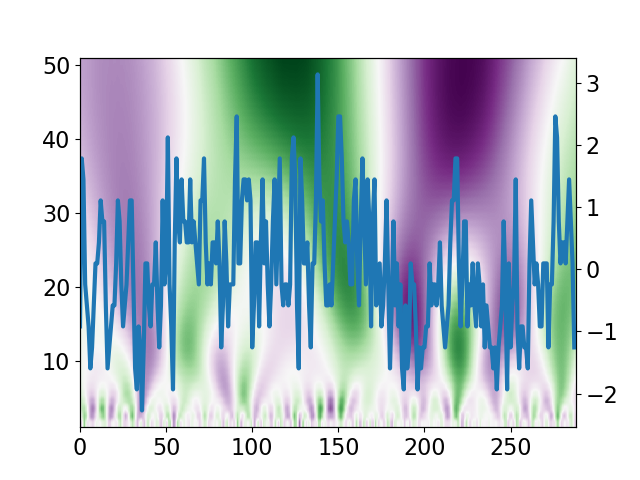

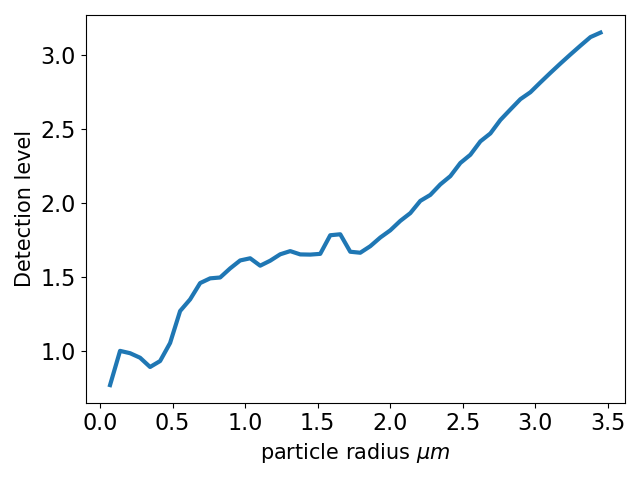

In [129]:
i=5
line =image_background[i,:]
# ax.plot(line)
ZMUV_signal = (line-np.mean(line))/np.std(line)
sig  = ZMUV_signal
widths = np.arange(1, width_max)

cwtmatr = signal.cwt(sig, signal.ricker, widths)
cwtmatr_yflip = np.flipud(cwtmatr)
# fig,ax =plt.subplots()
fig,ax =plt.subplots()
# transform = cwtmatr_yflip/np.array([np.flip(widths) for i in range(cwtmatr_yflip.shape[1])]).transpose()**2
transform = cwtmatr_yflip

# ax.imshow(cwtmatr_yflip, extent=[0, len(sig), 1, 31], cmap='PRGn', aspect='auto',

#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
ax.imshow(transform, extent=[0, len(sig), 1, width_max], cmap='PRGn', aspect='auto',

           vmax=abs(transform).max(), vmin=-abs(transform).max())
ax2 = ax.twinx()
ax2.plot(sig)
fig,ax =plt.subplots()
frequency_background = np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(image.shape[1])]).transpose(),axis=1)
# ax.plot(np.flip(widths)*space_pixel_size/2,np.mean(abs(cwtmatr_yflip),axis=1))
ax.plot(np.flip(widths)*space_pixel_size/2,np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(image.shape[1])]).transpose(),axis=1))

ax.set_xlabel('particle radius $\mu m$')
ax.set_ylabel('Detection level')
plt.tight_layout()

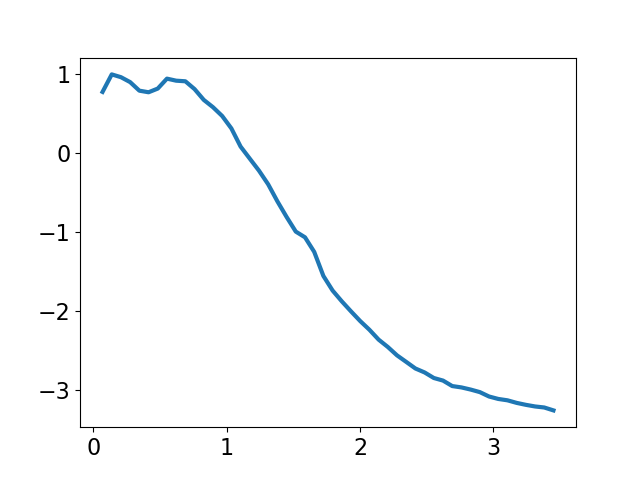

In [130]:
fig,ax =plt.subplots()
ax.plot(np.flip(widths)*space_pixel_size/2,frequency_background-freq_low)